In [237]:
#install libraries if needed
#conda install pandas numpy matplotlib scipy

In [238]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from scipy.interpolate import interp1d

LOAD DATA

In [239]:
# loading data for charging_df
file_path = 'data/charger_battery_data.csv'
data = pd.read_csv(file_path)

# calculate energy from power
data['e_production'] = data['p_production'] / 4
data['e_consumption'] = data['p_consumption'] / 4
data['e_charger'] = data['p_charger'] / 4

columns_to_drop = ['p_production', 'p_consumption', 'p_charger', 'p_grid_feedin', 'p_grid_purchase', 'p_battery_charge', 'p_battery_discharge', 'soc']
charging_df = data.drop(columns=columns_to_drop)

charging_df

,timestamp,serial,charger_id,transaction_id,e_production,e_consumption,e_charger
0,2020-11-01 01:00:00+01:00,39824.0,083f7321-7fc1-457e-b1d3-60008a3a0ab1,NaN,0.0,73.0,NaN
1,2020-11-01 01:15:00+01:00,39824.0,083f7321-7fc1-457e-b1d3-60008a3a0ab1,NaN,0.0,94.0,NaN
2,2020-11-01 01:30:00+01:00,39824.0,083f7321-7fc1-457e-b1d3-60008a3a0ab1,NaN,0.0,84.0,NaN
3,2020-11-01 01:45:00+01:00,39824.0,083f7321-7fc1-457e-b1d3-60008a3a0ab1,NaN,0.0,63.0,NaN
4,2020-11-01 02:00:00+01:00,39824.0,083f7321-7fc1-457e-b1d3-60008a3a0ab1,NaN,0.0,62.0,NaN
...,...,...,...,...,...,...,...
1817394,2021-10-31 23:45:00+01:00,61890.0,ff870cef-9ebb-4e3b-9706-a244f63337fd,86.0,0.0,376.0,0.0
1817395,2021-11-01 00:00:00+01:00,61890.0,ff870cef-9ebb-4e3b-9706-a244f63337fd,86.0,0.0,127.0,0.0
1817396,2021-11-01 00:15:00+01:00,61890.0,ff870cef-9ebb-4e3b-9706-a244f63337fd,86.0,0.0,81.0,0.0
1817397,2021-11-01 00:30:00+01:00,61890.0,ff870cef-9ebb-4e3b-9706-a244f63337fd,86.0,0.0,83.0,0.0


In [240]:
# create set of chargers from charging_df
charging_ids_set = set(charging_df['charger_id'])
len(charging_ids_set)

86

In [241]:
# loading data for transactions_df
file_path = 'data/sonnen_charger_db_public_transaction.csv'
transactions_df = pd.read_csv(file_path, delimiter=';')

# Conversions and formats
transactions_df['smart_charging_time'] = transactions_df['smart_charging_time'] / (60 * 1e9) / 60 # convert from ns to h. comment out / 60 to convert to minutes instead.
transactions_df['start_date'] = pd.to_datetime(transactions_df['start_date'], dayfirst=True)
transactions_df['end_date'] = pd.to_datetime(transactions_df['end_date'], dayfirst=True)

# Variable selection and filtering
columns_to_drop = ['amps_max', 'amps_min', 'begin_value_energy_wh', 'charged_km', 'created_at', 'note', 'end_value_energy_wh', 'server_id', 'archived']
transactions_df = transactions_df[transactions_df['charger_id'].isin(charging_ids_set)].drop(columns=columns_to_drop)
transactions_df = transactions_df[(transactions_df['start_date'] >= '2020-11-01') & (transactions_df['start_date'] < '2021-12-01')]

# Calculating the connection duration in minutes and hours
transactions_df['con_dur_m'] = (transactions_df['end_date'] - transactions_df['start_date']).dt.total_seconds() / 60
transactions_df['con_dur_h'] = transactions_df['con_dur_m'] / 60

# Display the first few rows of the prepared transactions data frame
transactions_df

,id,charged_energy_wh,charger_car_id,charger_id,charging_mode,end_date,smart_charging_time,start_date,transaction_id,con_dur_m,con_dur_h
23,76b8444f-00ab-4c22-8d52-f15bb77af575,8913.0,d28d93a0-01b4-4e45-b653-577b35c60be3,083f7321-7fc1-457e-b1d3-60008a3a0ab1,0.0,2020-11-07 22:00:53,4.3525,2020-11-07 15:42:33,477,378.333333,6.305556
24,089087d9-391c-4810-b6ab-8c02f18ae6ef,9112.0,d28d93a0-01b4-4e45-b653-577b35c60be3,083f7321-7fc1-457e-b1d3-60008a3a0ab1,1.0,2020-11-09 20:56:35,0.0000,2020-11-09 16:49:40,478,246.916667,4.115278
25,e134d4e4-e126-46bf-9c40-b9e50c90483a,8988.0,d28d93a0-01b4-4e45-b653-577b35c60be3,083f7321-7fc1-457e-b1d3-60008a3a0ab1,1.0,2020-11-25 22:44:30,0.0000,2020-11-25 18:41:53,479,242.616667,4.043611
26,39b02901-3610-4013-8f38-2d12a1b05046,9195.0,d28d93a0-01b4-4e45-b653-577b35c60be3,083f7321-7fc1-457e-b1d3-60008a3a0ab1,1.0,2020-11-27 07:10:36,0.0000,2020-11-26 19:52:47,480,677.816667,11.296944
27,f0059d0b-995a-4d39-b250-7fe15ff3f285,9291.0,d28d93a0-01b4-4e45-b653-577b35c60be3,083f7321-7fc1-457e-b1d3-60008a3a0ab1,1.0,2020-11-29 16:43:11,0.0000,2020-11-29 12:33:47,481,249.400000,4.156667
...,...,...,...,...,...,...,...,...,...,...,...
9717,741771af-167d-4aed-9e33-88c180d4ae41,34562.0,f414f247-25ba-4b00-88e0-e048c47db5d4,ff870cef-9ebb-4e3b-9706-a244f63337fd,1.0,2021-11-13 09:26:53,0.0000,2021-11-12 13:44:24,89,1182.483333,19.708056
9718,4f66d550-7b04-4adf-9dc7-291f85105e99,37056.0,f414f247-25ba-4b00-88e0-e048c47db5d4,ff870cef-9ebb-4e3b-9706-a244f63337fd,1.0,2021-11-18 06:34:01,0.0000,2021-11-17 16:06:24,90,867.616667,14.460278
9719,6cec60df-da24-473a-acd7-c799d874f17f,31636.0,f414f247-25ba-4b00-88e0-e048c47db5d4,ff870cef-9ebb-4e3b-9706-a244f63337fd,1.0,2021-11-23 06:37:45,0.0000,2021-11-22 19:03:25,91,694.333333,11.572222
9720,d7651dac-7b01-4a82-9090-e004139e8a7d,27197.0,f414f247-25ba-4b00-88e0-e048c47db5d4,ff870cef-9ebb-4e3b-9706-a244f63337fd,1.0,2021-11-26 06:33:35,0.0000,2021-11-25 18:05:08,92,748.450000,12.474167


In [242]:
# create set of chargers from transactions_df
transactions_ids_set = set(transactions_df['charger_id'])
len(transactions_ids_set)

84

In [243]:
# chargers in charging_df, but not transactions_df
transactions_ids_set.symmetric_difference(charging_ids_set)

{'2b1a8403-c849-4d75-901f-0bdeb0b14d45',
 'cf70d145-647d-4b01-9abb-a69fff0ec591'}

In [244]:
# examin first (earlierst) transactions per charger
transactions_df.groupby('charger_id')['start_date'].min()

charger_id
083f7321-7fc1-457e-b1d3-60008a3a0ab1   2020-11-07 15:42:33
1239bc55-e66e-43c2-ae86-2073c9f5df83   2021-02-11 16:56:52
12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64   2020-11-06 11:56:51
13ab39f6-574c-4065-860b-36145cd86e03   2020-11-01 11:49:15
14733b1c-6f7c-4b7a-8075-c3de0f155762   2020-11-24 14:18:27
                                               ...        
dcc6cfb4-8d92-4930-a5f0-732dfea4cf24   2021-01-14 01:20:40
df0b3099-7ffb-45db-9546-5148f48c7a1a   2020-11-30 20:36:47
e8cfcdf9-c4fd-4189-97e0-cbcf0ee89ac6   2021-06-28 11:52:12
fb1ad464-dbc6-482b-ac69-57932fe9d7cf   2021-01-19 12:40:06
ff870cef-9ebb-4e3b-9706-a244f63337fd   2021-01-27 16:51:24
Name: start_date, Length: 84, dtype: datetime64[ns]

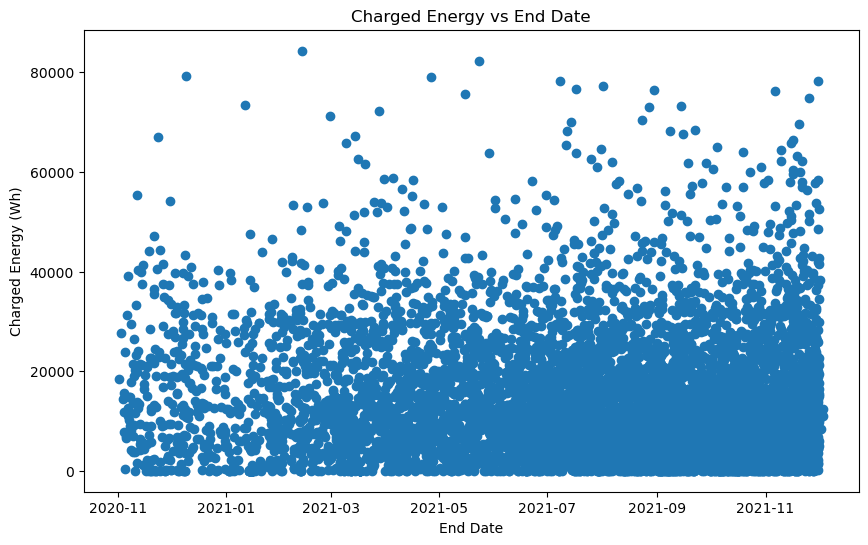

In [245]:
# View all transacitons over the year
plt.figure(figsize=(10, 6))
plt.scatter(transactions_df['end_date'], transactions_df['charged_energy_wh'])
plt.xlabel('End Date')
plt.ylabel('Charged Energy (Wh)')
plt.title('Charged Energy vs End Date')
plt.show()

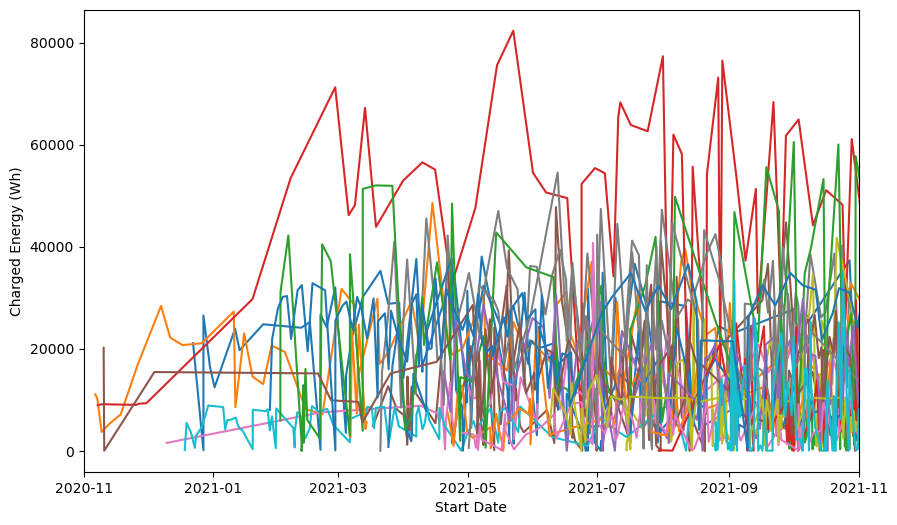

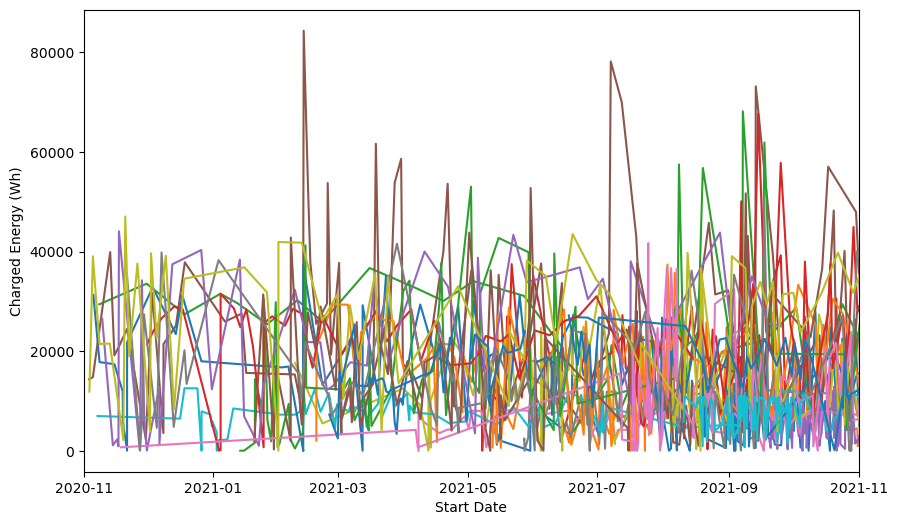

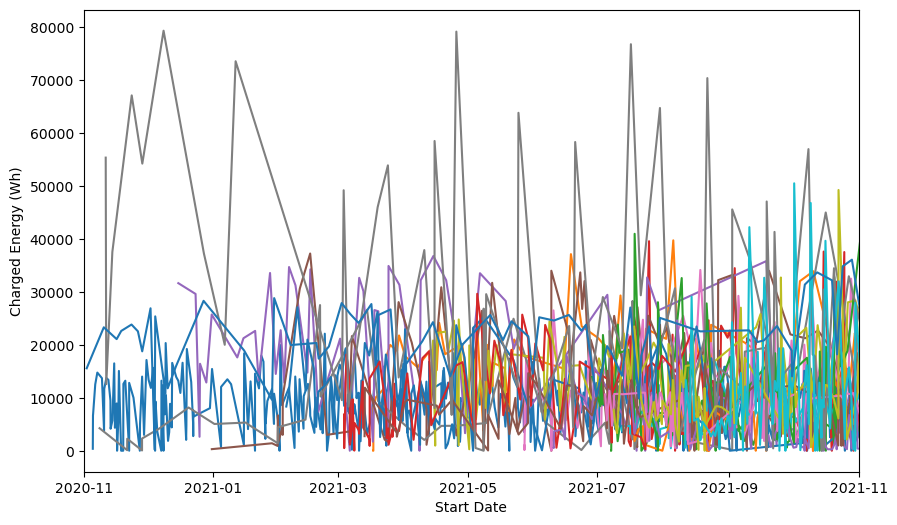

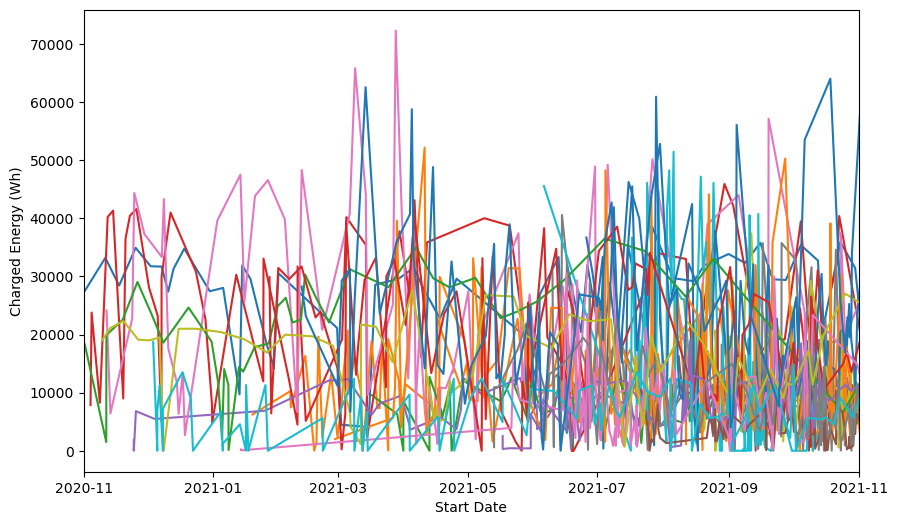

In [246]:
# examine all transaction start dates throughout the year

plots_per_figure = 21

for i, charger_id in enumerate(transactions_ids_set):
    if i % plots_per_figure == 0:
        plt.figure(figsize=(10, 6))
        plt.xlabel('Start Date')
        plt.ylabel('Charged Energy (Wh)')
        plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-11-01'))
    
    charger_transactions = transactions_df[transactions_df['charger_id'] == charger_id]
    
    # Adding the plot to the current figure
    plt.plot(charger_transactions['start_date'], charger_transactions['charged_energy_wh'], label=f'Charger ID: {charger_id}')
    
    # Showing the figure and starting a new one every 'plots_per_figure' iterations
    if (i + 1) % plots_per_figure == 0 or (i + 1) == len(transactions_ids_set):
        plt.show()


In [247]:
# chargers with at least 1 transaction in first and in last 2 months

# Filtering transactions_df for transactions with a date in 2020-11 and in 2021-10&11
transactions_2020_11 = transactions_df[transactions_df['start_date'] < '2020-12-01']
transactions_2021_10 = transactions_df[transactions_df['start_date'] >= '2021-10-01']

# Finding the unique charger_ids that have at least one transaction in both 2020-11 and 2021-10
set1 = set(transactions_df[transactions_df['start_date'] < '2020-12-01']['charger_id'])
set2 = set(transactions_df[transactions_df['start_date'] >= '2021-10-01']['charger_id'])
chargers_set = set1.intersection(set2)

print(len(chargers_set))

21


-> 21 chargers provide data for the whole year.
Closer look at these 21 chargers:

In [248]:
# Creating a DataFrame with the sum of smart_charging_time and con_dur_h for each charger_id
chargers_df = transactions_df[transactions_df['charger_id'].isin(chargers_set)].groupby('charger_id').agg({'smart_charging_time': 'sum', 'con_dur_h': 'sum', 'charged_energy_wh': 'sum'}).reset_index()

# Renaming the columns
chargers_df.columns = ['charger_id', 'total_smart_charging', 'total_connection_duration', 'total_charge_kwh']

chargers_df['total_charge_kwh'] = chargers_df['total_charge_kwh'] / 1000

# smart charging percentage of energy
chargers_df['smart_charging_p'] = chargers_df['total_smart_charging'] / chargers_df['total_connection_duration']

chargers_df


,charger_id,total_smart_charging,total_connection_duration,total_charge_kwh,smart_charging_p
0,083f7321-7fc1-457e-b1d3-60008a3a0ab1,345.042222,969.797778,3092.561,0.355788
1,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,582.908333,691.775833,1665.466,0.842626
2,13ab39f6-574c-4065-860b-36145cd86e03,118.930833,160.080833,986.733,0.742942
3,14733b1c-6f7c-4b7a-8075-c3de0f155762,5.959444,1330.733333,697.111,0.004478
4,18970a62-9803-4e39-b447-d5be93bf1bb3,124.785556,218.591944,568.399,0.570861
5,24e99152-102f-498e-8b20-067da9e8f1f6,926.986944,1193.120833,2206.370,0.776943
6,2d5cda8c-74d8-4566-97e3-5a5a25c81139,268.326389,343.989722,1278.954,0.780042
7,32b69085-f46d-4607-903b-6e16ad64acea,1540.150278,1763.198056,1686.470,0.873498
8,42caa860-48a0-4249-8aec-394f50eee6cd,0.000000,331.264444,723.747,0.000000
9,478d7741-5a98-4a2d-bde9-54665320f395,720.956111,766.078333,1788.852,0.941100


In [249]:
# filter transactions_df for those ids
transactions_df = transactions_df[transactions_df['charger_id'].isin(chargers_df['charger_id'])]

In [250]:
# New IDs for the 21 chargers in all df (chargers, transactions, charging)

chargers_df = chargers_df.rename(columns={'charger_id': 'charger_id_org'})
charger_id_dict = {charger_id: i+1 for i, charger_id in enumerate(chargers_df['charger_id_org'].unique())}
chargers_df['charger_id'] = chargers_df['charger_id_org'].map(charger_id_dict)

transactions_df = transactions_df.rename(columns={'charger_id': 'charger_id_org'})
transactions_df['charger_id'] = transactions_df['charger_id_org'].map(charger_id_dict)

charging_df = charging_df.rename(columns={'charger_id': 'charger_id_org'})
charging_df['charger_id'] = charging_df['charger_id_org'].map(charger_id_dict)

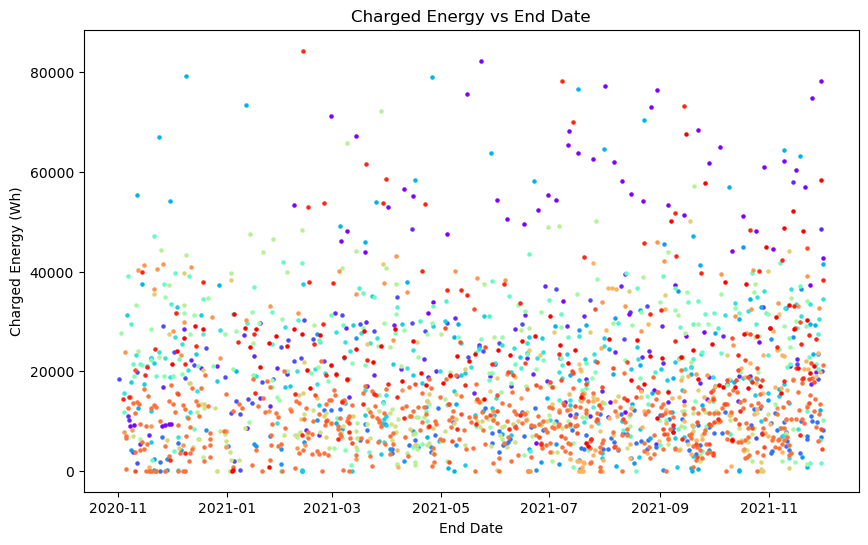

In [251]:
# View transactions of 21 chargers in scatter plot

colors = plt.cm.rainbow(np.linspace(0, 1, len(chargers_df['charger_id'])))
color_dict = dict(zip(chargers_df['charger_id'], colors))

# Creating the scatter plot
plt.figure(figsize=(10, 6))
for i, charger_id in enumerate(chargers_df['charger_id']):
    plt.scatter(transactions_df[transactions_df['charger_id'] == charger_id]['end_date'], 
                transactions_df[transactions_df['charger_id'] == charger_id]['charged_energy_wh'], 
                color=color_dict[charger_id],
                label=charger_id, s = 5)
plt.xlabel('End Date')
plt.ylabel('Charged Energy (Wh)')
plt.title('Charged Energy vs End Date')
plt.show()


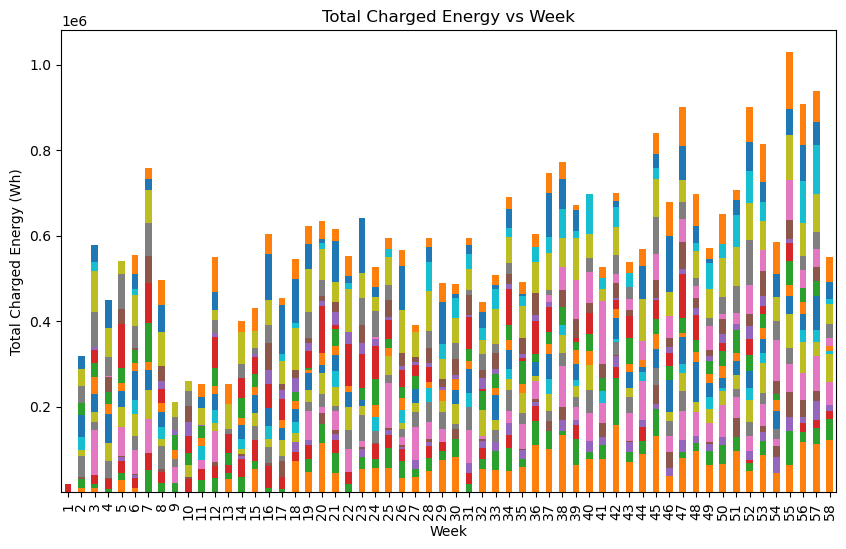

In [252]:
# View transactions of 21 chargers in stacked bars plot

# Extracting the date from 'end_date'
transactions_df['end_date_day'] = pd.to_datetime(transactions_df['end_date'].dt.date)

# Grouping the data by 'end_date' and 'charger_id', and summing 'charged_energy_wh'
grouped_df = transactions_df.groupby(['end_date_day', 'charger_id'])['charged_energy_wh'].sum()

# Resampling the data to weekly frequency
weekly_df = grouped_df.reset_index().set_index('end_date_day').groupby('charger_id').resample('W').sum()

# Unstacking the 'charger_id' level to create a DataFrame where each column corresponds to a charger_id
unstacked_df = weekly_df.unstack(level='charger_id')

# Creating the stacked bar chart
ax = unstacked_df.plot(kind='bar', stacked=True, figsize=(10, 6), legend=False)
ax.set_xticklabels(range(1, len(unstacked_df.index) + 1))
plt.xlabel('Week')
plt.ylabel('Total Charged Energy (Wh)')
plt.title('Total Charged Energy vs Week')
plt.show()


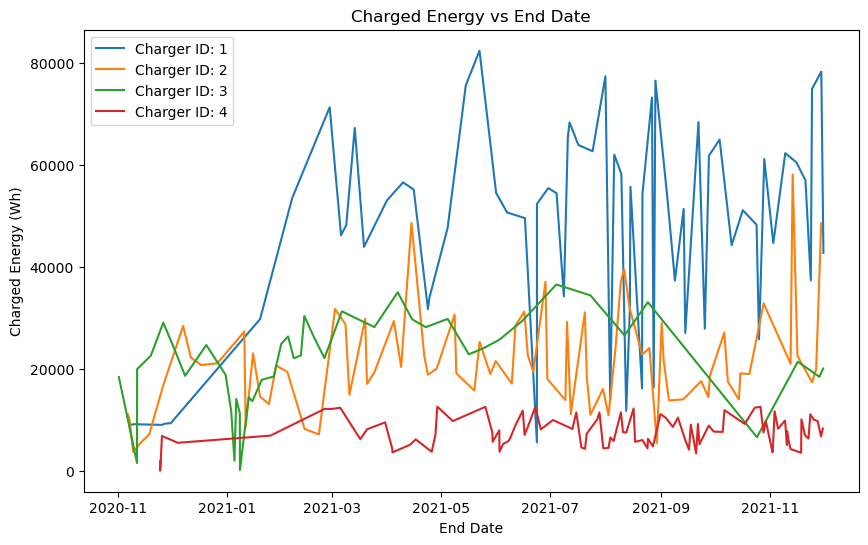

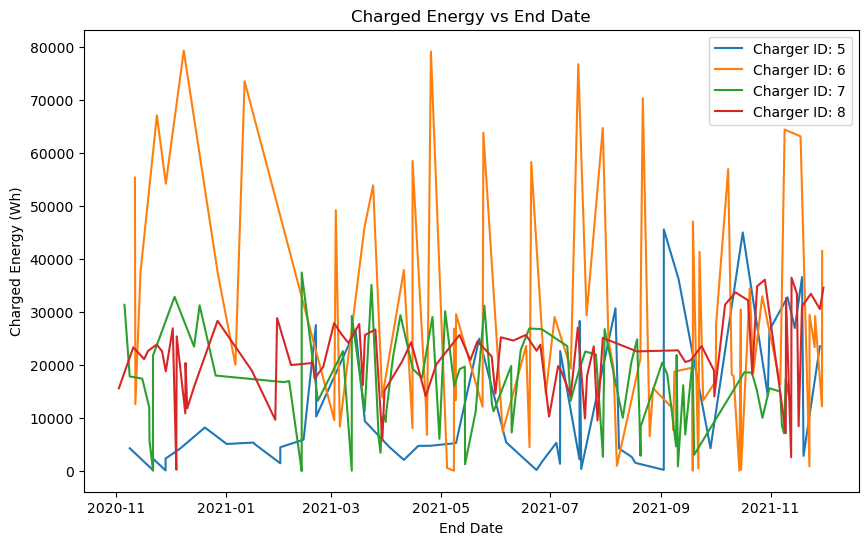

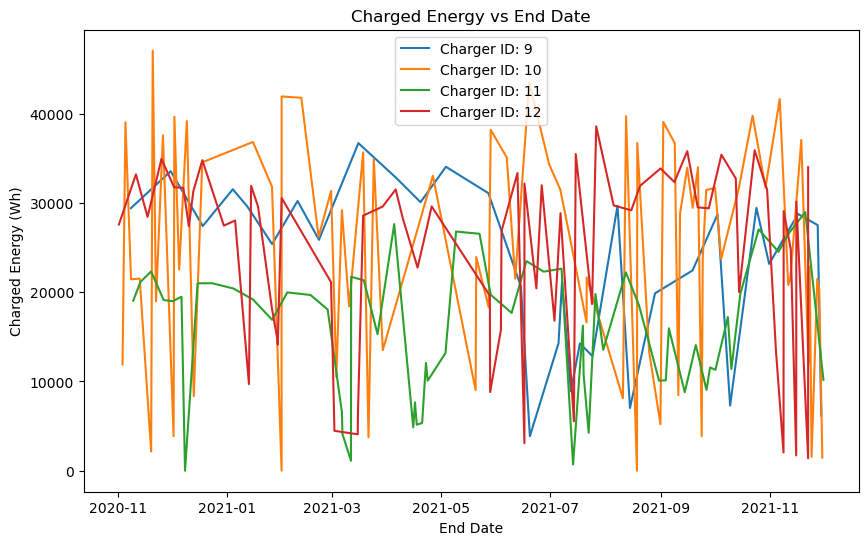

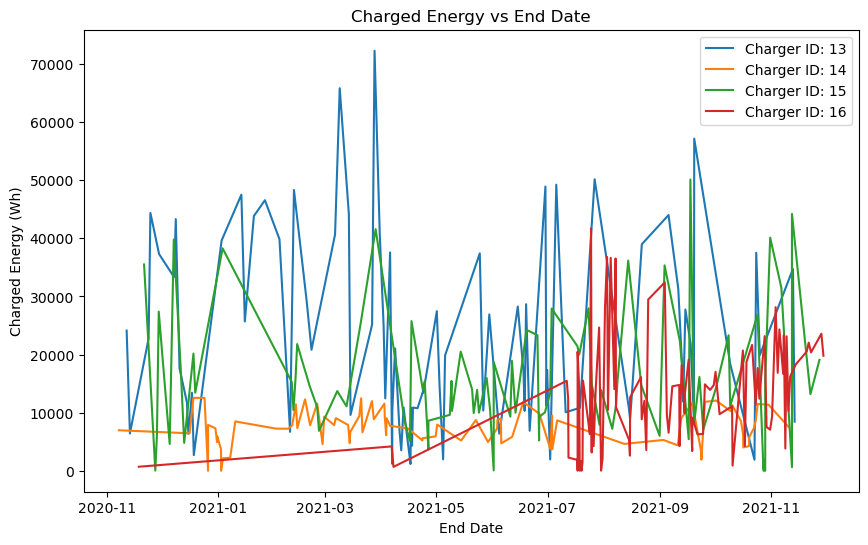

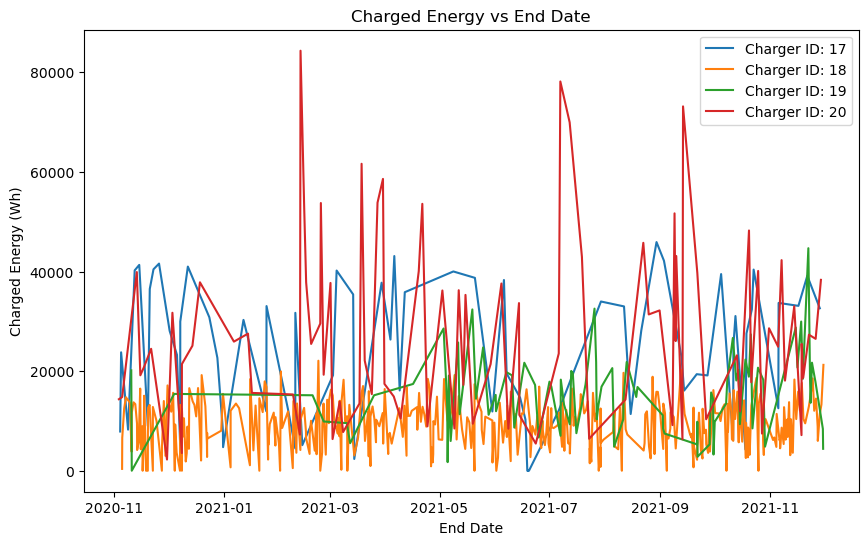

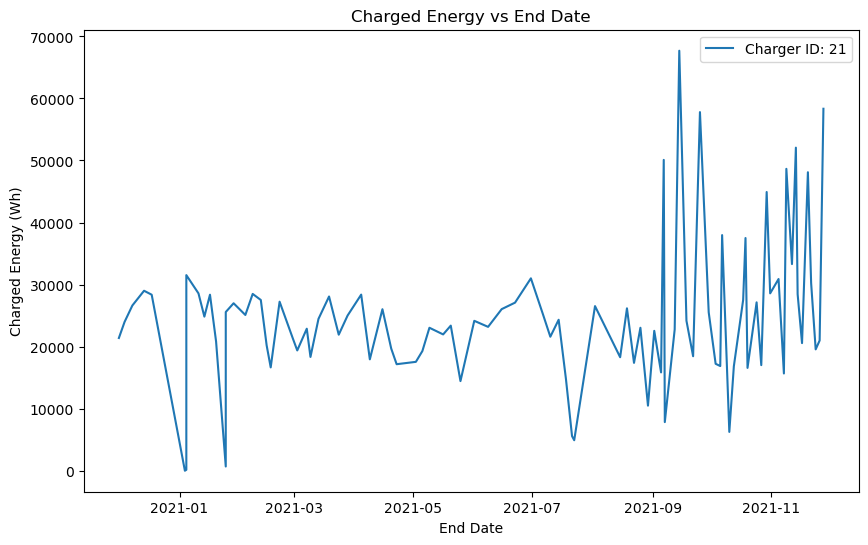

In [253]:
# View transactions in line plots
colors = plt.cm.rainbow(np.linspace(0, 1, len(chargers_df['charger_id'])))

# Creating a dictionary to map each charger_id to a unique color
color_dict = dict(zip(chargers_df['charger_id'], colors))

plots_per_figure = 4

# Looping over the filtered charger_ids
for i, charger_id in enumerate(chargers_df['charger_id']):
    # Creating a new figure every 'plots_per_figure' iterations
    if i % plots_per_figure == 0:
            plt.figure(figsize=(10, 6))
    # Creating the scatter plot
    charger_transactions = transactions_df[transactions_df['charger_id'] == charger_id]
    plt.plot(charger_transactions['start_date'], charger_transactions['charged_energy_wh'], label=f'Charger ID: {charger_id}')
    plt.xlabel('End Date')
    plt.ylabel('Charged Energy (Wh)')
    plt.title('Charged Energy vs End Date')
    plt.legend()
    if (i + 1) % plots_per_figure == 0 or (i + 1) == len(transactions_ids_set):
        plt.show()


ID 16 should be excluded ??

In [254]:
# devide charging_dfs into one df per charger

charging_dfs = {}  # Create an empty dictionary to store your DataFrames
for i, charger_id in enumerate(chargers_df['charger_id']):
    charging_dfs[charger_id] = charging_df[charging_df['charger_id'] == charger_id]

In [255]:
# View missing values in charging_dfs
for charger_id in charging_dfs.keys():
    charging_df = charging_dfs[charger_id]
    print(f"Charger ID: {charger_id}")
    print('Length: ', len(charging_df))
    for column in ["e_production", "e_consumption"]:
        num_of_nans = charging_df[column].isna().sum()
        print(f"Number of NaNs in {column}: {num_of_nans}")
    print("\n")

Charger ID: 1
Length:  35040
Number of NaNs in e_production: 20
Number of NaNs in e_consumption: 20


Charger ID: 2
Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0


Charger ID: 3
Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0


Charger ID: 4
Length:  23939
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0


Charger ID: 5
Length:  35040
Number of NaNs in e_production: 4
Number of NaNs in e_consumption: 4


Charger ID: 6
Length:  35040
Number of NaNs in e_production: 6
Number of NaNs in e_consumption: 6


Charger ID: 7
Length:  35040
Number of NaNs in e_production: 1
Number of NaNs in e_consumption: 1


Charger ID: 8
Length:  35040
Number of NaNs in e_production: 3
Number of NaNs in e_consumption: 3


Charger ID: 9
Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0


Charger ID: 10
Length:  35040
Number of NaNs in e_production: 73
Number of NaNs in e_consumption: 

dfs not looking good: 4, 11, 13, 14, 15, 16, 19, 20, 21. Also missing over 2hs of data: 1, 10, 12

In [256]:
charging_dfs_copy = charging_dfs.copy()

In [257]:
#charging_dfs = charging_dfs_copy.copy()

In [258]:
# Exclude chargers with many missing values 
## Maybe insert 1 and 12 again? 40 missing values = 10h

exclude = [1, 4, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21]
for charger_id in exclude:
    if charger_id in charging_dfs:
        del charging_dfs[charger_id]

charging_dfs.keys()

dict_keys([2, 3, 5, 6, 7, 8, 9, 17, 18])

charger_Id 5, e_production: Missing values were found and filled at these indices:
Index: 181799, Filled value: 5.4322980761523386e-08


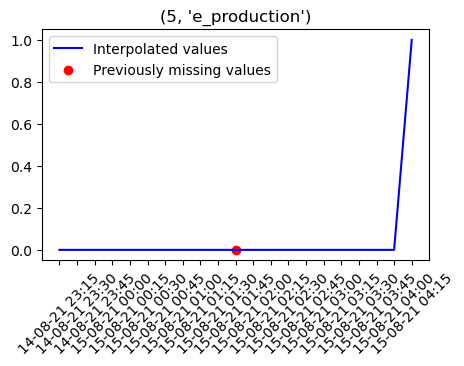

Index: 181837, Filled value: 1042.763403141185
Index: 181838, Filled value: 806.3667223613804


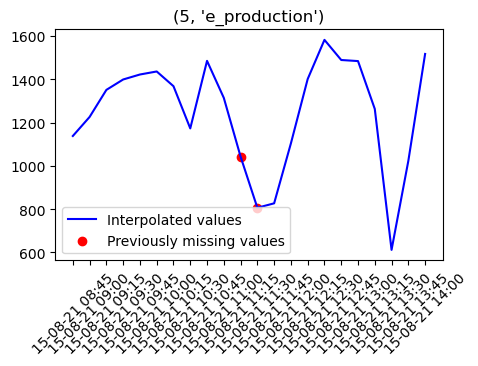

Index: 182352, Filled value: 0.0


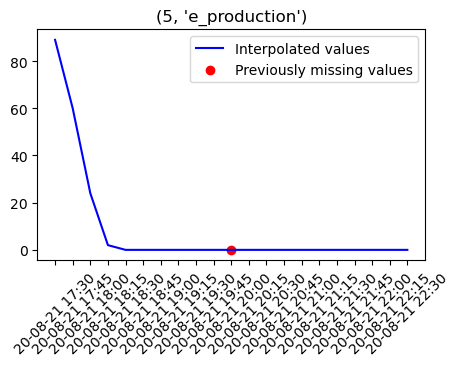

charger_Id 5, e_consumption: Missing values were found and filled at these indices:
Index: 181799, Filled value: 64.53525296424988


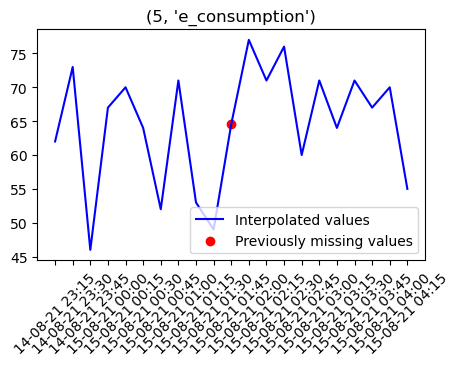

Index: 181837, Filled value: 81.61224184834595
Index: 181838, Filled value: 134.7859073963289


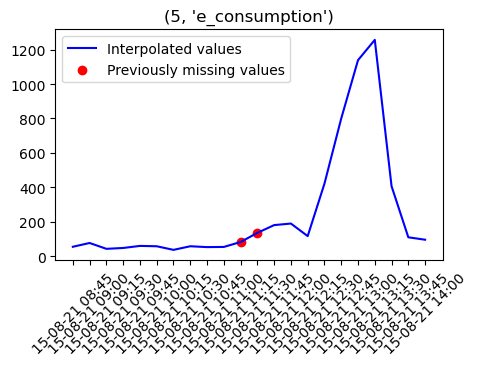

Index: 182352, Filled value: 100.50856445519358


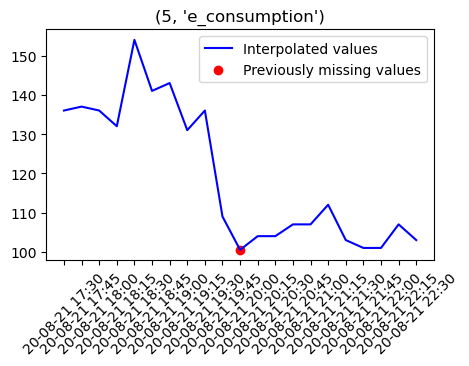

charger_Id 6, e_production: Missing values were found and filled at these indices:
Index: 242143, Filled value: 0.0
Index: 242144, Filled value: 0.0
Index: 242145, Filled value: 0.0
Index: 242146, Filled value: 0.0
Index: 242147, Filled value: 0.0
Index: 242148, Filled value: 164.74830910294452


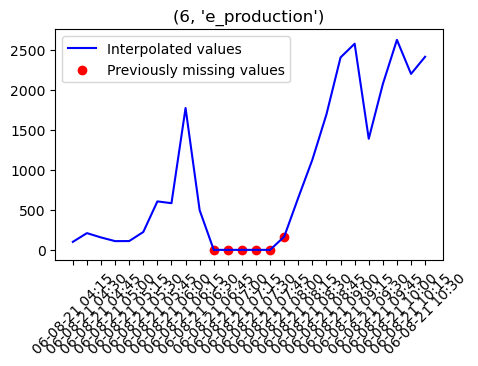

charger_Id 6, e_consumption: Missing values were found and filled at these indices:
Index: 242143, Filled value: 45.2121898164413
Index: 242144, Filled value: 41.16455638478508
Index: 242145, Filled value: 60.85709970503135
Index: 242146, Filled value: 105.08514548115888
Index: 242147, Filled value: 178.6206479370401
Index: 242148, Filled value: 282.25893277665386


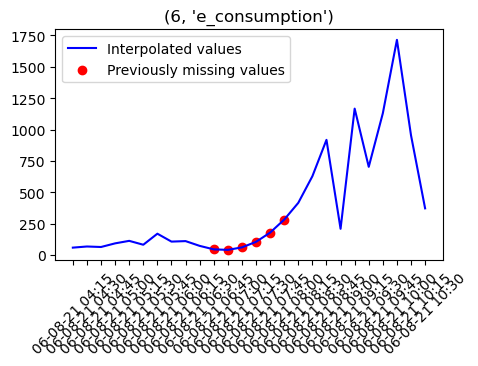

charger_Id 7, e_production: Missing values were found and filled at these indices:
Index: 308702, Filled value: 541.687191249359


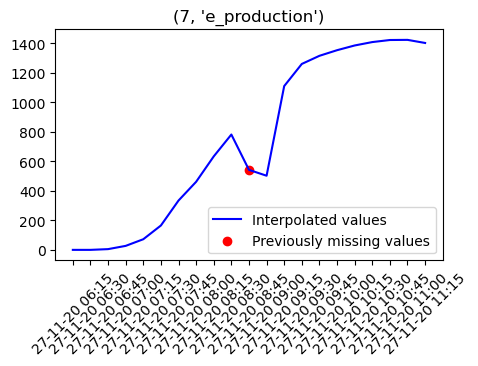

charger_Id 7, e_consumption: Missing values were found and filled at these indices:
Index: 308702, Filled value: 212.79841183962293


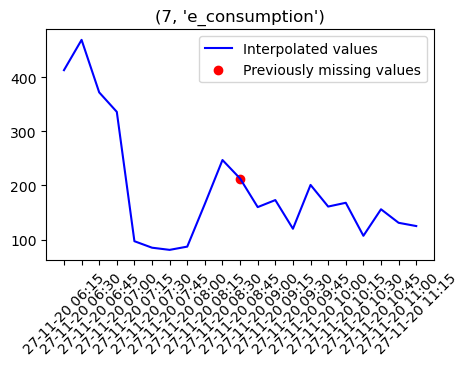

charger_Id 8, e_production: Missing values were found and filled at these indices:
Index: 378746, Filled value: 804.3220478645957
Index: 378747, Filled value: 422.70165364636813
Index: 378748, Filled value: 364.48043260495666


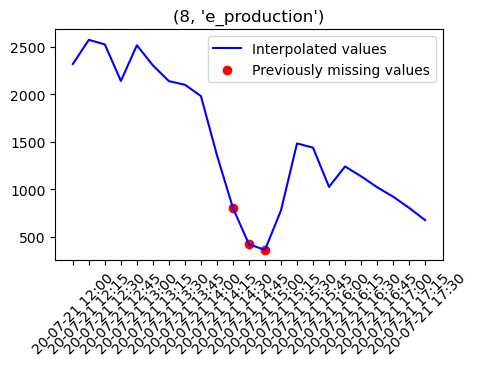

charger_Id 8, e_consumption: Missing values were found and filled at these indices:
Index: 378746, Filled value: 29.227046378074853
Index: 378747, Filled value: 0.0
Index: 378748, Filled value: 39.02116845734806


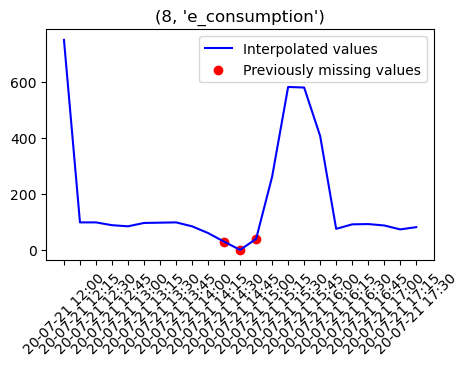

In [259]:
# fill missing values uqing quadratic interpolation and plot filled values with surrounding

def plot_filled_values(df, i, k, id, col):
    timestamps1 = pd.to_datetime(df['timestamp'][df.loc[i-(k+10):i+10,col].index])
    timestamps2 = pd.to_datetime(df['timestamp'][range(i-k,i+1)])
    # Plotting
    plt.figure(figsize=(5, 3))
    plt.plot(timestamps1, df.loc[i-(k+10):i+10,col], color='blue', label='Interpolated values')                    
    plt.scatter(timestamps2, df.loc[i-k:i,col], color='red', label='Previously missing values')
    plt.legend()
    plt.title((id, col))
    plt.xticks(timestamps1, rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
    plt.show()

for id in charging_dfs.keys():
    for col in ['e_production', 'e_consumption']:
        missing = charging_dfs[id][col].isnull()
        charging_dfs[id][col] = charging_dfs[id][col].interpolate(method='quadratic').clip(lower=0)

        if missing.sum() == 0:
            continue

        # Print indices of previously missing values and their new values
        print(f"charger_Id {id}, {col}: Missing values were found and filled at these indices:")

        k = 0
        indices = charging_dfs[id][missing].index

        for n, i in enumerate(indices):
            print(f"Index: {i}, Filled value: {charging_dfs[id].loc[i, col]}")

            if n < len(indices) - 1:
                if indices[n] + 1 == indices[n+1]:
                    k += 1
                else:
                    plot_filled_values(charging_dfs[id], i, k, id, col)
                    k = 0
            else:
                plot_filled_values(charging_dfs[id], i, k, id, col)




In [260]:
# check for missing values again

for charger_id in charging_dfs.keys():
    charging_df = charging_dfs[charger_id]
    print(f"Charger ID: {charger_id}", ', Length: ', len(charging_df))
    for column in ["e_production", "e_consumption"]:
        num_of_nans = charging_df[column].isna().sum()
        print(f"Number of NaNs in {column}: {num_of_nans}")

Charger ID: 2 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 3 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 5 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 6 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 7 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 8 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 9 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 17 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0
Charger ID: 18 , Length:  35040
Number of NaNs in e_production: 0
Number of NaNs in e_consumption: 0


Now let's deal with missing charger values

In [261]:
# check for miss matches between charging_dfs and transactions_df.
# Also examine all single values (= very short charging transaction, under 15min)
# Fill missing values in charging per transaction.

for charger_id, charging_df in charging_dfs.items():
    print(f"Checking charger_id: {charger_id}")

    #check for mismatches between e_charger and transactions_df
    mismatch_rows = charging_df[(charging_df['transaction_id'].isna() & charging_df['e_charger'].notna()) | 
                                (charging_df['transaction_id'].notna() & charging_df['e_charger'].isna())]
    if not mismatch_rows.empty:
        print("     Mismatch found between e_charger and transaction_id in the following rows:")
        print(mismatch_rows[['transaction_id', 'e_charger']])
    else:
        print("     No mismatches between e_charger and transaction_id found.")

    # check for single values
    # Find rows where 'e_charger' is not NaN but the previous and next values are NaN
    charging_df['prev_p_charger'] = charging_df['e_charger'].shift(1)
    charging_df['next_p_charger'] = charging_df['e_charger'].shift(-1)
    single_value_rows = charging_df[charging_df['e_charger'].notna() & 
                                    charging_df['prev_p_charger'].isna() & 
                                    charging_df['next_p_charger'].isna()]

    if not single_value_rows.empty:
        print("     Single values found in the following rows:")
        print(single_value_rows[['transaction_id', 'e_charger']])
    else:
        print("     No single values found.")

    # For each single value, find and print the corresponding rows in transactions_df
    for index, row in single_value_rows.iterrows():
        corresponding_rows = transactions_df[(transactions_df['charger_id_org'] == row['charger_id_org']) & 
                                             (transactions_df['transaction_id'] == row['transaction_id'])]
        if not corresponding_rows.empty:
            print(f"Corresponding rows in transactions_df for charger_id {row['charger_id_org']} and transaction_id {row['transaction_id']}:")
            print(corresponding_rows[['charged_energy_wh', 'start_date', 'end_date', 'transaction_id']])



    # Drop the temporary columns
    charging_df.drop(['prev_p_charger', 'next_p_charger'], axis=1, inplace=True)

Checking charger_id: 2
     No mismatches between e_charger and transaction_id found.
     No single values found.
Checking charger_id: 3
     No mismatches between e_charger and transaction_id found.
     No single values found.
Checking charger_id: 5
     No mismatches between e_charger and transaction_id found.
     Single values found in the following rows:
        transaction_id   e_charger
179141          8106.0  329.716239
Corresponding rows in transactions_df for charger_id 18970a62-9803-4e39-b447-d5be93bf1bb3 and transaction_id 8106.0:
     charged_energy_wh          start_date            end_date  transaction_id
542              325.0 2021-07-18 09:21:33 2021-07-18 09:29:48            8106
Checking charger_id: 6
     No mismatches between e_charger and transaction_id found.
     Single values found in the following rows:
        transaction_id   e_charger
242238          2378.0  995.452991
248891          2402.0  264.533333
Corresponding rows in transactions_df for charger_id

In [262]:
# Examine energy chargerd in charging_df and compare to record in transactions_df

# Is the difference the 'charger efficiency?'

# probably not, since values are both below and above 1 - rather measuring/data inaccuracies?

for charger_id, charging_df in charging_dfs.items():
    transaction_id_set = set(charging_df['transaction_id'].dropna())

    
    for transaction in transaction_id_set:
        energy_charged = charging_df[charging_df['transaction_id'] == transaction]['e_charger'].sum()

        energy_received = transactions_df[((transactions_df['charger_id'] == charger_id) & (transactions_df['transaction_id'] == transaction))]['charged_energy_wh']
        if energy_received.empty:
            energy_received = 0
        else:
            energy_received = energy_received.iloc[0]

        charging_efficiency = energy_charged / energy_received

        print(charger_id, transaction, 'energy charged:', energy_charged, 'energy received:', energy_received, 'efficiency:', charging_efficiency)
    

2 13.0 energy charged: 0.0 energy received: 0 efficiency: nan
2 14.0 energy charged: 11021.148717948718 energy received: 11050.0 efficiency: 0.9973890242487528
2 15.0 energy charged: 10088.264713064713 energy received: 10112.0 efficiency: 0.9976527603901021
2 16.0 energy charged: 3655.213675213675 energy received: 3685.0 efficiency: 0.9919168725138874
2 17.0 energy charged: 5415.981766381767 energy received: 5421.0 efficiency: 0.999074297432534
2 18.0 energy charged: 7093.896752136752 energy received: 7111.0 efficiency: 0.997594818188265
2 19.0 energy charged: 16656.528360528362 energy received: 16722.0 efficiency: 0.9960847004262865
2 20.0 energy charged: 28063.26837606838 energy received: 28376.0 efficiency: 0.988979009587975
2 21.0 energy charged: 22109.196581196586 energy received: 22190.0 efficiency: 0.9963585660746546
2 22.0 energy charged: 20604.929914529916 energy received: 20701.0 efficiency: 0.9953591572643793
2 23.0 energy charged: 20991.915995115996 energy received: 21075.0

/tmp/ipykernel_3899386/4006334247.py:20: RuntimeWarning: invalid value encountered in scalar divide
  charging_efficiency = energy_charged / energy_received
/tmp/ipykernel_3899386/4006334247.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  charging_efficiency = energy_charged / energy_received


5 8111.0 energy charged: 0.0 energy received: 163.0 efficiency: 0.0
5 8112.0 energy charged: 45507.6344988345 energy received: 45558.0 efficiency: 0.99889447514892
5 8113.0 energy charged: 36092.307692307695 energy received: 36183.0 efficiency: 0.9974935105521293
5 8114.0 energy charged: 4216.784045584045 energy received: 4247.0 efficiency: 0.9928853415549906
5 8115.0 energy charged: 44849.11452991453 energy received: 44978.0 efficiency: 0.9971344775204439
5 8116.0 energy charged: 14194.680341880345 energy received: 14193.0 efficiency: 1.0001183922976358
5 8117.0 energy charged: 26458.62792022792 energy received: 26539.0 efficiency: 0.9969715482960141
6 2337.0 energy charged: 18213.6547008547 energy received: 0 efficiency: inf
6 2338.0 energy charged: 55171.928693528695 energy received: 55331.0 efficiency: 0.9971250961220418
6 2339.0 energy charged: 12529.935042735042 energy received: 12564.0 efficiency: 0.9972886853498123
6 2340.0 energy charged: 37419.21367521367 energy received: 375

Charging_dfs and transactions_df charged energy deviates 0.4-5% !!

In [263]:
# check difference aggregated per charger

for charger_id, charging_df in charging_dfs.items():
    transaction_id_set = set(charging_df['transaction_id'].dropna())

    energy_charged_total = 0
    energy_received_total = 0

    for transaction in transaction_id_set:
        energy_charged = charging_df[charging_df['transaction_id'] == transaction]['e_charger'].sum()

        energy_received = transactions_df[((transactions_df['charger_id'] == charger_id) & (transactions_df['transaction_id'] == transaction))]['charged_energy_wh']
        if not energy_received.empty:
            energy_received_total += energy_received.iloc[0]
            energy_charged_total += energy_charged

    charging_efficiency = energy_charged_total / energy_received_total
    print(charger_id, charging_efficiency)

2 0.9903719761704496
3 0.9964701156481149
5 0.9969217536359161
6 1.0100885282411591
7 0.9965689873659258
8 0.9773729630247163
9 0.947735839574389
17 0.9966564997355776
18 0.9962858554347814


In [264]:
# check for missing valaues in each transactions by looking for gaps in the index

def is_consecutive(df):
    return (df.index == range(df.index[0], df.index[-1] + 1)).all()

issues = 0

for charger_id, charging_df in charging_dfs.items():
    transaction_id_set = set(charging_df['transaction_id'].dropna())
    for transaction in transaction_id_set:
        filtered_df = charging_df[charging_df['transaction_id'] == transaction]
        if not is_consecutive(filtered_df):
            issues += 1
            print(f"The index for id {charger_id}, transaction {transaction} is NOT consecutive.")
    
    len(charging_df)

if issues == 0:
    print("None of the transactions in the charger IDs have missing values.")


None of the transactions in the charger IDs have missing values.


Now, let's create .csv of charging_dfs:  

In [266]:
for i, key in enumerate(charging_dfs.keys()):
    charging_dfs[key]['charger_id'] = i + 1
    if i + 1 > 9:
        filename = f"data/charger_battery_data_{i+1}.csv"
    else:
        filename = f"data/charger_battery_data_0{i+1}.csv"
    charging_dfs[key].to_csv(filename, index=False)
    charging_dfs[key]['timestamp'] = pd.to_datetime(charging_dfs[key]['timestamp'], utc=True)
    charging_dfs[key].set_index('timestamp', inplace=True)


DESCRIPTIVE ANALYSIS:

In [269]:

new_keys = range(1, len(charging_dfs) + 1)
charging_dfs = dict(zip(new_keys, charging_dfs.values()))


In [271]:
charging_dfs[1].index.dtype

datetime64[ns, UTC]

ChargerID: 1
       e_production  e_consumption    e_charger
count  35040.000000   35040.000000  2565.000000
mean     289.569578     120.152825   570.734188
std      502.016250     270.385342   671.467118
min        0.000000      12.000000     0.000000
25%        0.000000      38.000000     0.000000
50%        0.000000      51.000000     0.000000
75%      355.000000      70.000000  1185.750427
max     2325.000000    2640.000000  2510.605128


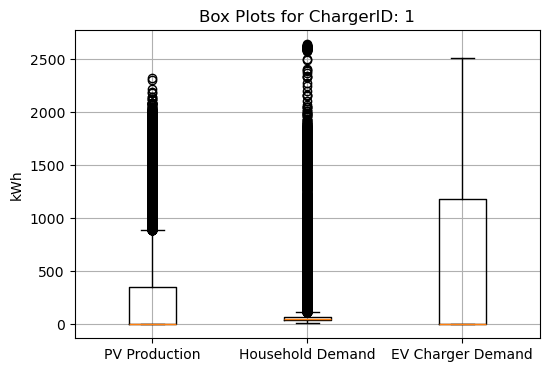

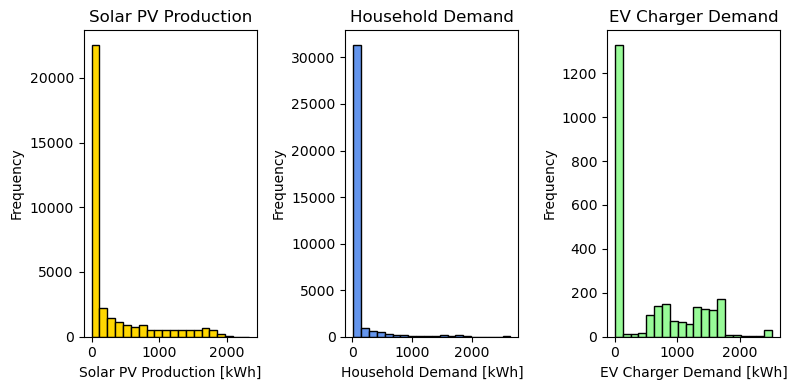

In [272]:
for i, df in charging_dfs.items():
    
    if i > 1:
        continue
    
    print("ChargerID:" ,i)
    print(df[['e_production', 'e_consumption', 'e_charger']].describe())

    # create a boxplot for each dataframe
    plt.figure(figsize=(6, 4))
    plt.boxplot([df[col].dropna() for col in ['e_production', 'e_consumption', 'e_charger']], labels=['PV Production', 'Household Demand', 'EV Charger Demand'])
    plt.ylabel('kWh')
    plt.title(f'Box Plots for ChargerID: {i}')
    plt.grid(True)
    plt.show()

    # create histograms for each dataframe
    plt.figure(figsize=(8, 4))
    for j, (col, color, title) in enumerate(zip(['e_production', 'e_consumption', 'e_charger'], ['gold', 'cornflowerblue', 'palegreen'], ['Solar PV Production', 'Household Demand', 'EV Charger Demand'])):
        plt.subplot(1, 3, j+1)
        plt.hist(df[col].dropna(), bins=20, color=color, edgecolor='black')
        plt.xlabel(f'{title} [kWh]')
        plt.ylabel('Frequency')
        plt.title(title)

    plt.tight_layout()
    #plt.savefig(f'histos_{i}.png', transparent=True, bbox_inches='tight')
    plt.show()



        e_production  e_consumption     e_charger
count  315360.000000  315360.000000  26091.000000
mean      314.439203     229.258627    484.023207
std       544.802339     333.864965    776.035927
min         0.000000       0.000000      0.000000
25%         0.000000      66.000000      0.000000
50%         0.000000     119.000000      0.000000
75%       396.000000     218.000000    967.541880
max      3321.000000    4825.000000   2585.340171


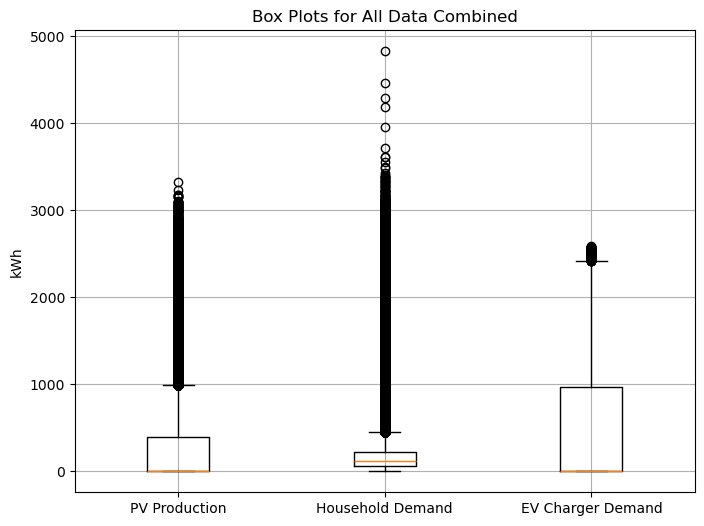

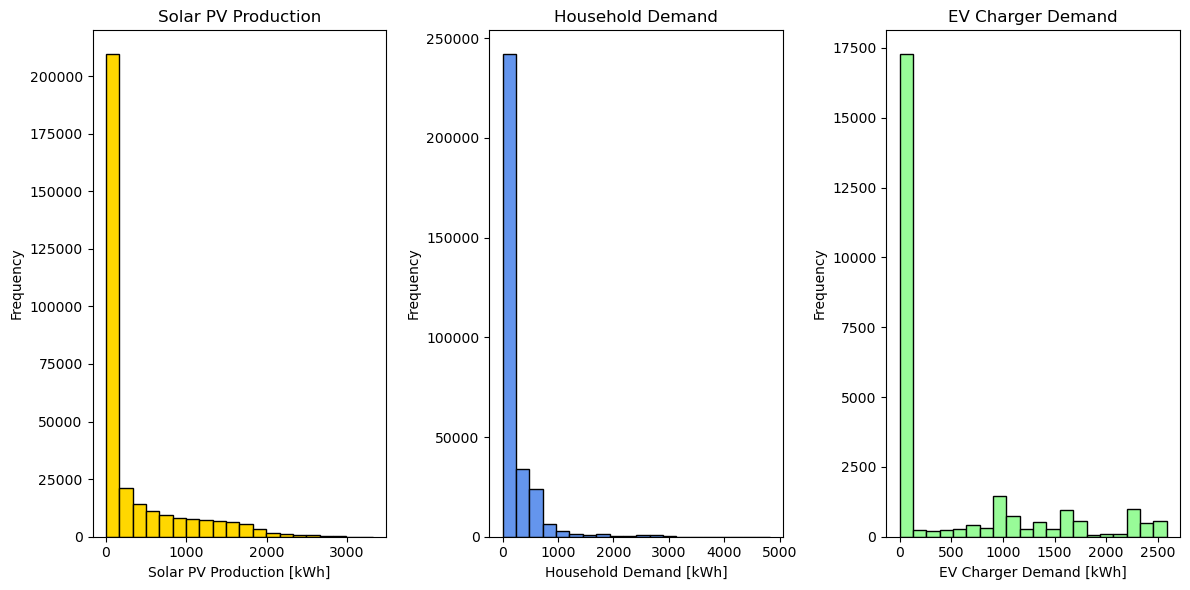

In [273]:
all_data = pd.concat(charging_dfs.values(), ignore_index=True)

# get descriptive statistics for the combined data
print(all_data[['e_production', 'e_consumption', 'e_charger']].describe())

# create a boxplot for the combined data
plt.figure(figsize=(8, 6))
plt.boxplot([all_data[col].dropna() for col in ['e_production', 'e_consumption', 'e_charger']], labels=['PV Production', 'Household Demand', 'EV Charger Demand'])
plt.ylabel('kWh')
plt.title('Box Plots for All Data Combined')
plt.grid(True)
plt.show()

# create histograms for the combined data
plt.figure(figsize=(12, 6))
for j, (col, color, title) in enumerate(zip(['e_production', 'e_consumption', 'e_charger'], ['gold', 'cornflowerblue', 'palegreen'], ['Solar PV Production', 'Household Demand', 'EV Charger Demand'])):
    plt.subplot(1, 3, j+1)
    plt.hist(all_data[col].dropna(), bins=20, color=color, edgecolor='black')
    plt.xlabel(f'{title} [kWh]')
    plt.ylabel('Frequency')
    plt.title(title)

plt.tight_layout()
plt.savefig('histos_all.png', transparent=True, bbox_inches='tight')
plt.show()


In [274]:
charging_dfs[1]

,serial,charger_id_org,transaction_id,e_production,e_consumption,e_charger,charger_id
timestamp,,,,,,,
2020-11-01 00:00:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,55.0,0.0,1
2020-11-01 00:15:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,37.0,0.0,1
2020-11-01 00:30:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,29.0,0.0,1
2020-11-01 00:45:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,29.0,0.0,1
2020-11-01 01:00:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,52.0,0.0,1
...,...,...,...,...,...,...,...
2021-10-31 22:45:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,NaN,0.0,41.0,NaN,1
2021-10-31 23:00:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,NaN,0.0,47.0,NaN,1
2021-10-31 23:15:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,NaN,0.0,64.0,NaN,1


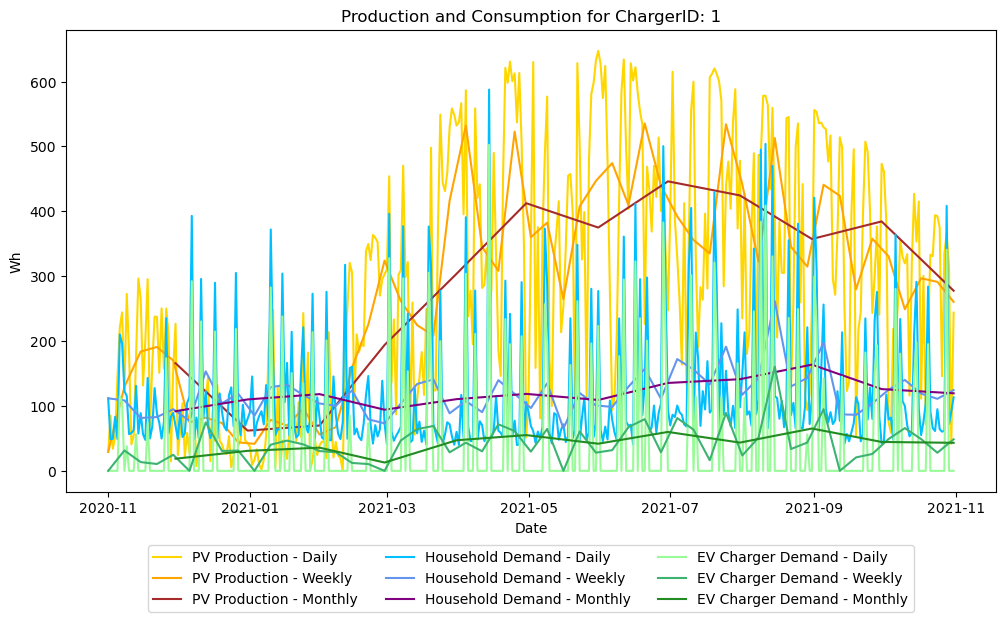

In [279]:
import matplotlib.pyplot as plt

# Define the colors for each group of plots
e_production_colors = ['gold', 'orange', 'brown']
e_consumption_colors = ['deepskyblue', 'cornflowerblue', 'purple']
e_charger_colors = ['palegreen', 'mediumseagreen', 'forestgreen']

# iterate over each dataframe in the dictionary
for i, df in charging_dfs.items():
    # fill NaNs in 'e_charger' with 0
    #df['e_charger'].fillna(0, inplace=True)
    
    df.fillna({'e_charger':0}, inplace=True)

    if i > 1:
        continue

    # Resample the time series to daily, weekly, and monthly frequencies
    plt.figure(figsize=(12, 6))
    plt.plot(df.resample('D')['e_production'].mean(), label='PV Production - Daily', color=e_production_colors[0])
    plt.plot(df.resample('W')['e_production'].mean(), label='PV Production - Weekly', color=e_production_colors[1])
    plt.plot(df.resample('ME')['e_production'].mean(), label='PV Production - Monthly', color=e_production_colors[2])

    plt.plot(df.resample('D')['e_consumption'].mean(), label='Household Demand - Daily', color=e_consumption_colors[0])
    plt.plot(df.resample('W')['e_consumption'].mean(), label='Household Demand - Weekly', color=e_consumption_colors[1])
    plt.plot(df.resample('ME')['e_consumption'].mean(), label='Household Demand - Monthly', color=e_consumption_colors[2])

    plt.plot(df.resample('D')['e_charger'].mean(), label='EV Charger Demand - Daily', color=e_charger_colors[0])
    plt.plot(df.resample('W')['e_charger'].mean(), label='EV Charger Demand - Weekly', color=e_charger_colors[1])
    plt.plot(df.resample('ME')['e_charger'].mean(), label='EV Charger Demand - Monthly', color=e_charger_colors[2])

    plt.xlabel('Date')
    plt.ylabel('Wh')

    # Move the legend underneath the plot and make it wider with multiple columns
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    plt.title(f'Production and Consumption for ChargerID: {i}')

    # Save the figure with transparent background
    #plt.savefig(f'Production_and_Consumption_{i}.png', transparent=True, bbox_inches='tight')

    plt.show()


In [281]:
charging_dfs[1]

,serial,charger_id_org,transaction_id,e_production,e_consumption,e_charger,charger_id
timestamp,,,,,,,
2020-11-01 00:00:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,55.0,0.0,1
2020-11-01 00:15:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,37.0,0.0,1
2020-11-01 00:30:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,29.0,0.0,1
2020-11-01 00:45:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,29.0,0.0,1
2020-11-01 01:00:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,13.0,0.0,52.0,0.0,1
...,...,...,...,...,...,...,...
2021-10-31 22:45:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,NaN,0.0,41.0,0.0,1
2021-10-31 23:00:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,NaN,0.0,47.0,0.0,1
2021-10-31 23:15:00+00:00,137530.0,12e31b6c-969b-4a0a-b8ad-9be5eb2e5f64,NaN,0.0,64.0,0.0,1


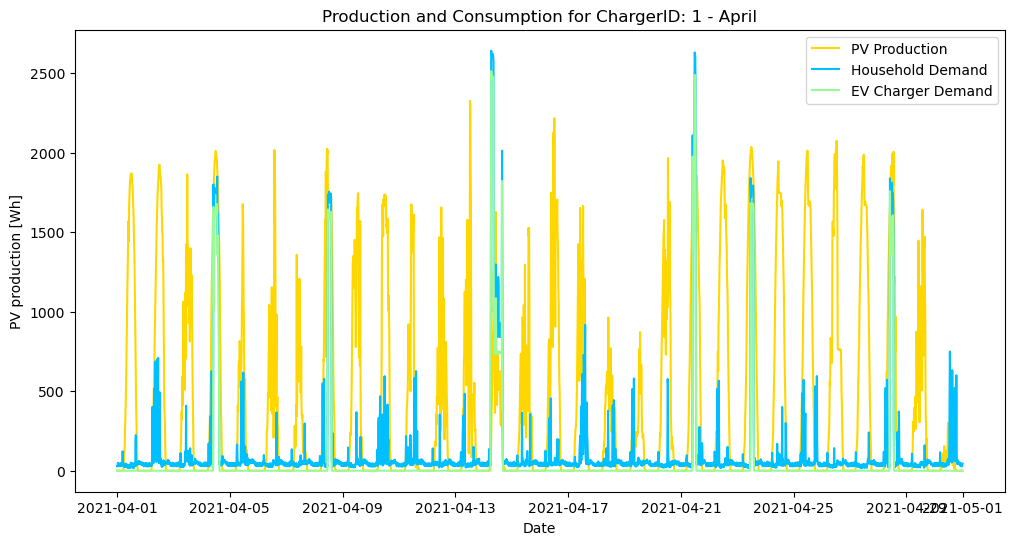

In [287]:

for i, df in charging_dfs.items():
    # fill NaNs in 'e_charger' with 0
    df.fillna({'e_charger':0}, inplace=True)

    if i > 1:
        continue

    plt.figure(figsize=(12, 6))
    # Plot the PV production data for April
    ax1 = plt.gca()
    e_production_line, = ax1.plot(df.loc['2021-04', 'e_production'], label='PV Production', color=e_production_colors[0])

    # Plot the Electrical Demand data for April
    e_consumption_line, = ax1.plot(df.loc['2021-04', 'e_consumption'], label='Household Demand', color=e_consumption_colors[0])

    # Plot the EV Charger Demand data for April
    e_charger_line, = ax1.plot(df.loc['2021-04', 'e_charger'], label='EV Charger Demand', color=e_charger_colors[0])


    ax1.set_xlabel('Date')
    ax1.set_ylabel('PV production [Wh]')
    ax1.set_title(f'Production and Consumption for ChargerID: {i} - April')

    # Combine the legend handles and labels from both axes
    lines = [e_production_line, e_consumption_line, e_charger_line]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    # Save the figure with transparent background
    #plt.savefig(f'Production_and_Consumption_{i}_April.png', transparent=True)

    plt.show()


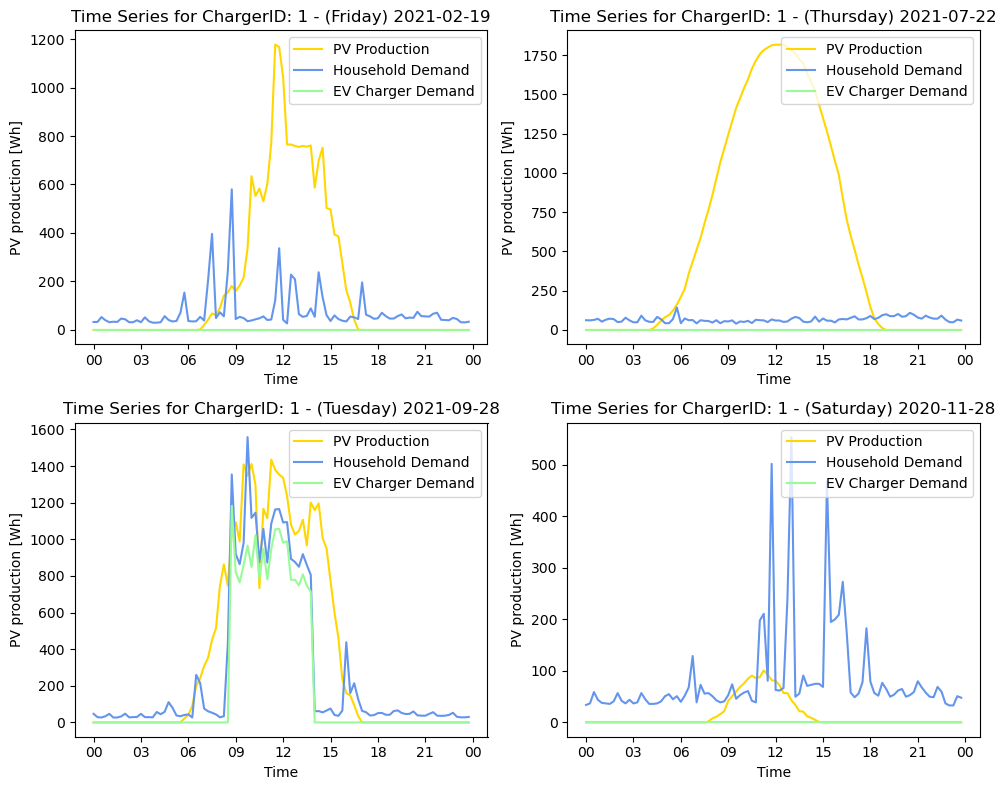

In [291]:
import matplotlib.pyplot as plt
from datetime import datetime

# Define the colors for each group of plots
e_production_colors = ['gold', 'khaki', 'yellow']
e_consumption_colors = ['cornflowerblue', 'deepskyblue', 'dodgerblue']
e_charger_colors = ['palegreen', 'mediumseagreen', 'forestgreen']

# Dates for which you want to plot the data
dates = ['2021-02-19', '2021-07-22', '2021-09-28', '2020-11-28']

# Create subplots grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# iterate over each dataframe in the dictionary
for i, df in charging_dfs.items():
    # fill NaNs in 'e_charger' with 0
    df.fillna({'e_charger':0}, inplace=True)

    if i > 1:
        continue

    # Plotting loop
    for j, date in enumerate(dates):
        # Determine the subplot position
        row = j // 2
        col = j % 2

        # Get the corresponding axis
        ax = axes[row, col]

        # Plot the PV production data for the specific date
        ax.plot(df.loc[date, 'e_production'], label='PV Production', color=e_production_colors[0])#, linestyle='dotted', linewidth=0.5)

        # Plot the Electrical Demand data for the specific date
        ax.plot(df.loc[date, 'e_consumption'], label='Household Demand', color=e_consumption_colors[0])#, linestyle='dotted', linewidth=0.5)

        # Plot the EV Charger Demand data for the specific date
        ax.plot(df.loc[date, 'e_charger'], label='EV Charger Demand', color=e_charger_colors[0])#, linestyle='dotted', linewidth=0.5)

        #ax.set_ylim(0, 3.5)

        # Change x axis format to just hours
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H'))

        # extract weekday name
        specific_date = datetime.strptime(date, "%Y-%m-%d").date()
        weekday = specific_date.strftime("%A")

        # Customize the plot
        ax.set_xlabel('Time')
        ax.set_ylabel('PV production [Wh]')
        ax.set_title(f'Time Series for ChargerID: {i} - ({weekday}) {date}')

        # Combine the legends from both axes
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='upper right')

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Save the plots in one figure and remove the background (make it transparent)
    #fig.savefig(f'four_days_plots_{i}.png', transparent=True)

    # Display the plots
    plt.show()
